In [1]:
from datasets import load_dataset
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from PIL import Image
import io
import base64



In [2]:
# Učitavanje WikiArt dataset-a
dataset = load_dataset('huggan/wikiart')

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

In [3]:
train_subset = dataset['train'].select(range(int(0.002 * len(dataset['train']))))
#train_subset = dataset['train'][:1000]

In [4]:
# Podela na train, validation, i test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train_subset.to_pandas(), test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_df, test_size=0.5, random_state=42)


In [5]:
class WikiArtDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_to_idx=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_data = self.dataframe.iloc[idx]['image']
        image_bytes = image_data['bytes']
        image = Image.open(io.BytesIO(image_bytes))

        label = self.dataframe.iloc[idx]['genre']

        # Mapiranje oznaka (labels) koristeći class_to_idx
        if self.class_to_idx is not None:
            label = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
# Definišite transformacije
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
# Dobijanje broja klasa
classes = train_df['genre'].unique()
num_classes = len(classes)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}


In [8]:

train_dataset = WikiArtDataset(train_df, transform=transform, class_to_idx=class_to_idx)
valid_dataset = WikiArtDataset(valid_df, transform=transform, class_to_idx=class_to_idx)
test_dataset = WikiArtDataset(test_df, transform=transform, class_to_idx=class_to_idx)


In [9]:
# Mapiranje klase do indeksa
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
print(f"Class to index mapping: {class_to_idx}")


Class to index mapping: {4: 0, 6: 1, 2: 2, 8: 3, 7: 4, 9: 5, 3: 6, 1: 7, 10: 8, 5: 9}


In [10]:
def create_vgg16_model(num_classes):
    model = models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model


In [11]:
# Definišite model AlexNet
def create_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model


In [12]:
from torch.optim.lr_scheduler import StepLR

def train_model(model, train_loader, valid_loader, num_epochs=15, learning_rate=0.0001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays the learning rate by a factor of 0.1 every 5 epochs

    best_accuracy = 0.0
    train_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Evaluacija na validacionom skupu
        model.eval()
        valid_labels = []
        valid_preds = []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                valid_labels.extend(labels.cpu().numpy())
                valid_preds.extend(preds.cpu().numpy())

        accuracy = accuracy_score(valid_labels, valid_preds)
        valid_accuracies.append(accuracy)
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    return train_losses, valid_accuracies



In [13]:
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    model.eval()
    test_labels = []
    test_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [14]:
# Funkcija za konverziju Dataset objekta u DataLoader
def get_dataloaders(train_dataset, valid_dataset, test_dataset, batch_size=16):
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, valid_loader, test_loader


In [15]:
# Kreirajte DataLoader-e
train_loader, valid_loader, test_loader = get_dataloaders(train_dataset, valid_dataset, test_dataset)


In [16]:
# Debugging funkcija za provere pre treninga
def debug_dataloader(loader):
    for i, (images, labels) in enumerate(loader):
        print(f"Batch {i+1}:")
        print(f" - Images shape: {images.shape}")
        print(f" - Labels shape: {labels.shape}")
        print(f" - Labels: {labels}")
        if i == 0:
            break

In [17]:
def debug_model(model, loader):
    for images, labels in loader:
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        print("Passing a single batch through the model for debugging...")
        outputs = model(images)
        print(f" - Output shape: {outputs.shape}")
        break


In [18]:
print("Training VGGNet...")
vgg16_model = create_vgg16_model(num_classes)
print("Model created successfully.")

Training VGGNet...


/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created successfully.


Starting Epoch 1/15
Epoch 1/15, Loss: 2.2712
Validation Accuracy: 41.18%
Starting Epoch 2/15
Epoch 2/15, Loss: 2.0548
Validation Accuracy: 47.06%
Starting Epoch 3/15
Epoch 3/15, Loss: 1.8829
Validation Accuracy: 47.06%
Starting Epoch 4/15
Epoch 4/15, Loss: 1.6668
Validation Accuracy: 35.29%
Starting Epoch 5/15
Epoch 5/15, Loss: 1.5043
Validation Accuracy: 23.53%
Starting Epoch 6/15
Epoch 6/15, Loss: 1.2479
Validation Accuracy: 35.29%
Starting Epoch 7/15
Epoch 7/15, Loss: 1.1364
Validation Accuracy: 52.94%
Starting Epoch 8/15
Epoch 8/15, Loss: 1.0568
Validation Accuracy: 47.06%
Starting Epoch 9/15
Epoch 9/15, Loss: 0.9739
Validation Accuracy: 47.06%
Starting Epoch 10/15
Epoch 10/15, Loss: 0.9087
Validation Accuracy: 47.06%
Starting Epoch 11/15
Epoch 11/15, Loss: 0.8190
Validation Accuracy: 47.06%
Starting Epoch 12/15
Epoch 12/15, Loss: 0.8659
Validation Accuracy: 52.94%
Starting Epoch 13/15
Epoch 13/15, Loss: 0.9040
Validation Accuracy: 41.18%
Starting Epoch 14/15
Epoch 14/15, Loss: 0.8

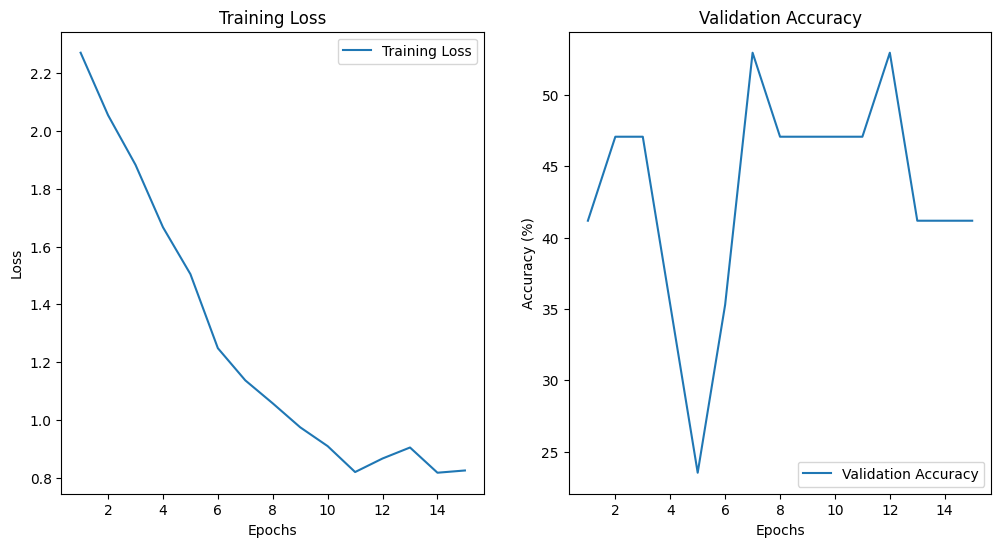

In [19]:
import matplotlib.pyplot as plt

train_losses, valid_accuracies = train_model(vgg16_model, train_loader, valid_loader)

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(valid_accuracies) + 1), [acc * 100 for acc in valid_accuracies], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


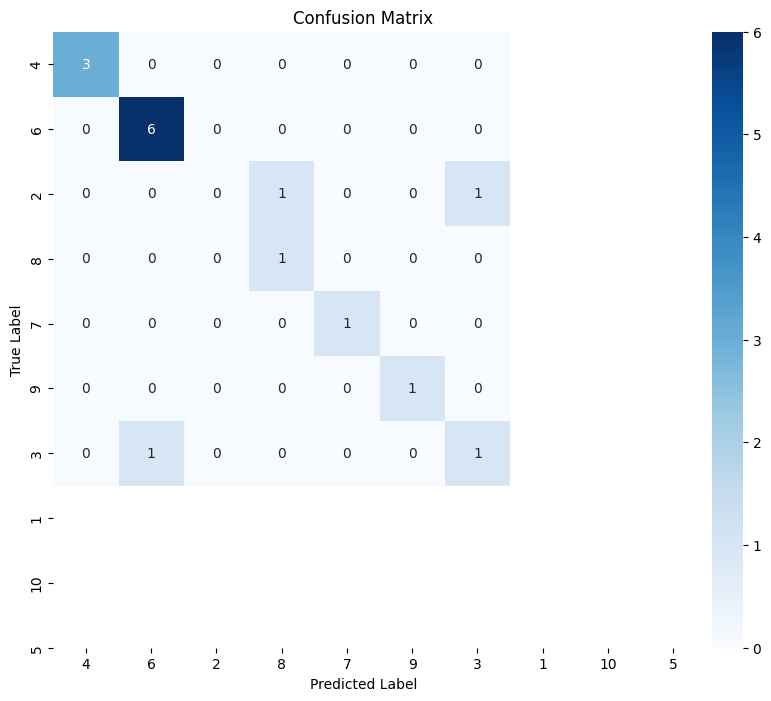

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    model.eval()
    test_labels = []
    test_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_to_idx.keys(), yticklabels=class_to_idx.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix after testing
plot_confusion_matrix(vgg16_model, test_loader)


In [21]:
# Debugging funkcija za provere pre treninga
"""def debug_dataloader(loader):
    for i, (images, labels) in enumerate(loader):
        print(f"Batch {i+1}:")
        print(f" - Images shape: {images.shape}")
        print(f" - Labels shape: {labels.shape}")
        print(f" - Labels: {labels}")
        if i == 0:
            break

# Provera modela
def debug_model(model, loader):
    for images, labels in loader:
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        print("Passing a single batch through the model for debugging...")
        outputs = model(images)
        print(f" - Output shape: {outputs.shape}")
        break

# Kreirajte i obučite VGGNet model sa dodanim proverenama
try:
    print("Training VGGNet...")
    vgg16_model = create_vgg16_model(num_classes)
    print("Model created successfully.")

    # Provera podataka
    debug_dataloader(train_loader)
    
    # Provera modela sa batch-om podataka
    debug_model(vgg16_model, train_loader)
    
    # Pokretanje treninga
    train_model(vgg16_model, train_loader, valid_loader)
except Exception as e:
    print(f"Error during training: {e}")

# Evaluacija VGGNet modela sa proverenama
try:
    print("Evaluating VGGNet...")
    evaluate_model(vgg16_model, test_loader)
except Exception as e:
    print(f"Error during evaluation: {e}")
"""

'def debug_dataloader(loader):\n    for i, (images, labels) in enumerate(loader):\n        print(f"Batch {i+1}:")\n        print(f" - Images shape: {images.shape}")\n        print(f" - Labels shape: {labels.shape}")\n        print(f" - Labels: {labels}")\n        if i == 0:\n            break\n\n# Provera modela\ndef debug_model(model, loader):\n    for images, labels in loader:\n        images = images.to(\'cuda\' if torch.cuda.is_available() else \'cpu\')\n        print("Passing a single batch through the model for debugging...")\n        outputs = model(images)\n        print(f" - Output shape: {outputs.shape}")\n        break\n\n# Kreirajte i obučite VGGNet model sa dodanim proverenama\ntry:\n    print("Training VGGNet...")\n    vgg16_model = create_vgg16_model(num_classes)\n    print("Model created successfully.")\n\n    # Provera podataka\n    debug_dataloader(train_loader)\n    \n    # Provera modela sa batch-om podataka\n    debug_model(vgg16_model, train_loader)\n    \n    # P

In [22]:
"""print("Training VGGNet...")
vgg16_model = create_vgg16_model(num_classes)
train_model(vgg16_model, train_loader, valid_loader)"""


'print("Training VGGNet...")\nvgg16_model = create_vgg16_model(num_classes)\ntrain_model(vgg16_model, train_loader, valid_loader)'